# Support Vector Machines from scratch

In [147]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix as mat
from cvxopt import solvers as solver
from sklearn.datasets import make_blobs

In [148]:
X, y = make_blobs(n_samples=200, n_features=2, centers=2)

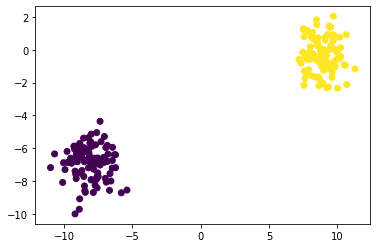

In [149]:
plt.scatter(X[:, 0], X[:, 1], c=y)

$$
    \large
    \max_{\boldsymbol{\sigma}; \boldsymbol{\sigma} \geq 0}  \sum_{i=1}^{N}\sigma_i - \frac{1}{2} \sum_{i=1}^{N}\sum_{j=1}^{N} \sigma_i \sigma_j y_i y_j \boldsymbol{x}_i^\top \boldsymbol{x}_j \\
    \large
    \min_{\boldsymbol{\sigma}; \boldsymbol{\sigma} \geq 0}  \frac{1}{2} \sum_{i=1}^{N}\sum_{j=1}^{N} \sigma_i \sigma_j y_i y_j \boldsymbol{x}_i^\top \boldsymbol{x}_j -  \sum_{i=1}^{N}\sigma_i  
$$


$$
\large
    P_{ij} = y_i y_j \boldsymbol{x}_i^\top\boldsymbol{x}_j
$$

$$
    \large
    \boldsymbol{w} = \sum_{i=1}^{N} y_i \sigma_i \boldsymbol{x}_i
$$

$$
    \large
    b = y_s - \sum_{m \in S} \sigma_m y_m \boldsymbol{x}_m^\top \boldsymbol{x}_s \\
    \text{where} \; S \; \text{is the set of support vectors such as} \; \sigma_i > 0
$$

- Compute $\boldsymbol{P}$.
- Compute $\boldsymbol{w}$.
- Find the support vectors $S$ by finding any data point where $\sigma_i > 0$.
- Compute $b$.
- To predict, compute $y_{test} = \text{sign}\left(\boldsymbol{w}^\top \boldsymbol{x}_{test} + b \right)$

CVXOPT form:
$$
    \min \frac{1}{2} \boldsymbol{x}^\top\boldsymbol{P}\boldsymbol{x} + \boldsymbol{q}^\top\boldsymbol{x}\\
    \text{s.t.} \\
    \boldsymbol{G}\boldsymbol{x} \leq h \\
    \boldsymbol{A}\boldsymbol{x} = 0
$$

In matrix form the dual optimization is:
$$
    \min \frac{1}{2} \boldsymbol{\sigma}^\top \boldsymbol{P} \boldsymbol{\sigma} - 1^\top\boldsymbol{\sigma} \\
    \text{s.t.} \\
    - \sigma_i \leq 0 \\
    \boldsymbol{y}^\top \boldsymbol{\sigma} = 0
$$

In [150]:
n_samples = X.shape[0]
n_features = X.shape[1]

In [151]:
y = np.expand_dims(y, 1).astype(float)

In [158]:
X_tmp = y * X
P = np.dot(X, X.T)

In [153]:
P = mat(P)
q = mat(-np.ones((n_samples, 1), dtype=np.float))
G = mat(-np.eye(n_samples, dtype=np.float))
h = mat(np.zeros((n_samples, 1), dtype=np.float))
A = mat(y.T)
b = mat(np.zeros(1, dtype=np.float))

In [154]:
solver.options['show_progress'] = False
solver.options['abstol'] = 1e-10
solver.options['reltol'] = 1e-10
solver.options['feastol'] = 1e-10

In [155]:
solution = solver.qp(P, q, G, h, A, b)

In [156]:
sigma = np.array(solution['x'])

In [140]:
w = ((y * sigma).T @ X).T

In [142]:
S = (sigma > 1e-4).flatten()

In [144]:
b = y[S] - np.dot(X[S], w)
b = b.squeeze()